# Application of the Delta Method

In this notebook, I go through an application of the Delta Method from Chapra and DiToro (1993) using least squares regression to fit the dissolved oxygen profile and the Approimate Delta Method (McBride and Chapra, 2005). Additionally, I have created a saturated dissolved oxygen model based on the equations presented in Lecture 19 of Chapra (2008). To demonstrate the application of these models, I will explore the primary production, respiration, and dissolved oxygen for Stroubles Creek in Blacksburg, Virginia.

Author: Billy Raseman, Graduate Research Assistant at University of Colorado Boulder

## Delta Method assumptions

Photosynthesis represented as a half-sinusoid. 

After 9:55 am, the clouds clear so the half-sinusoid assumption should be applicable. 
https://www.wunderground.com/history/airport/KBCB/2014/9/20/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

Plants are uniformly distributed for a sufficiently long distance  > 3U/k_a and deficit does not vary spatially and sufficiently far downstream of wastewater treatment plant.

## Water quality data

Data is provided by the Learning Enhanced Watershed Assessment System (LEWAS) Laboratory run by Dr. Vinod Lohani and Dr. Randel Dymond (pictured below).

"LEWAS is a real-time water and weather monitoring system developed to enhance water sustainability eduacation and research at Virginia Tech... [it] has sensors to measure water quality and quantity data including flow rate, depth, pH, dissolved oxygen, conductivity, and temperature." (http://www.lewas.centers.vt.edu/) See figure below for more details. 

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://www.lewas.centers.vt.edu/images/FlowDiagramWIPv2presentations-02.jpg")

## Case Study Location

Discussion of Stroubles Creek

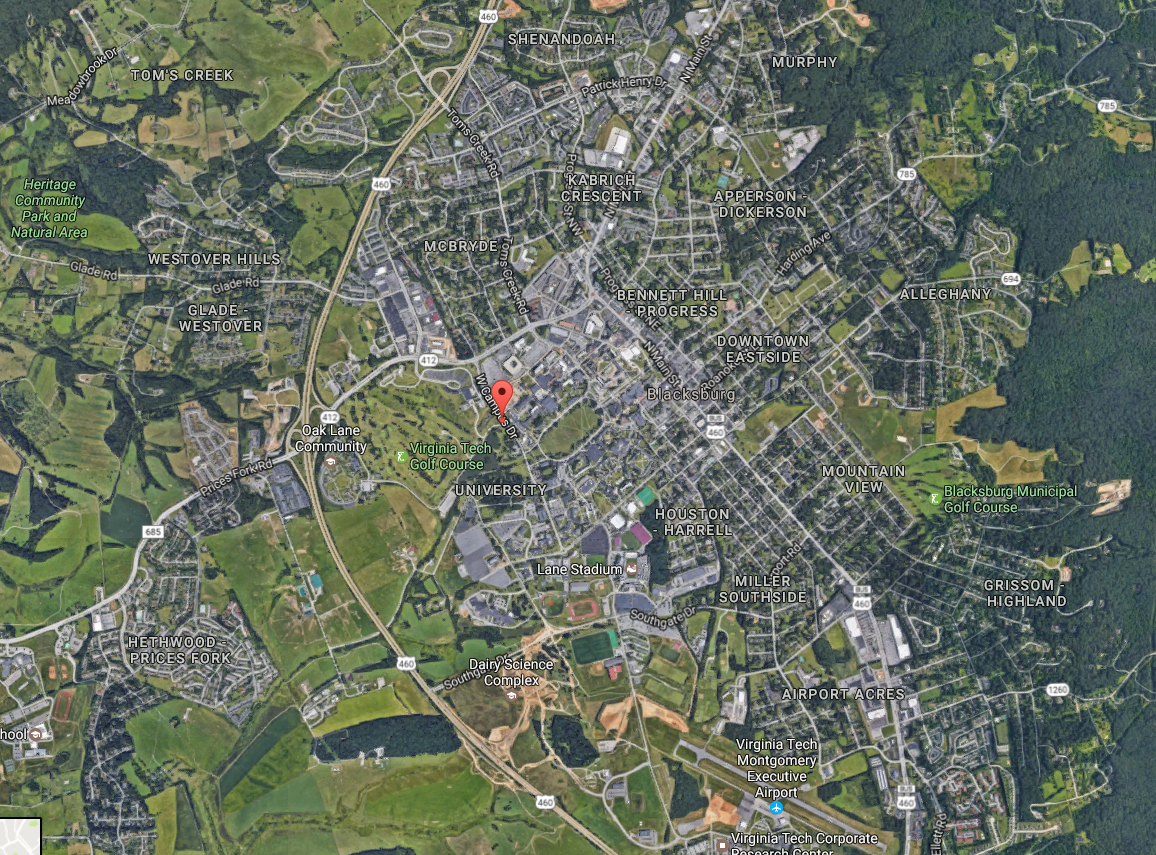

In [7]:
Image("stroubles_creek.png")

## Define saturated dissolved oxygen (DO) Model

In [8]:
def sat_dissolved_oxygen(temp_C, salinity, elev=None, pressure=None):

    """
    -------------------------------------------------------------------------------
    Purpose: Calculate the saturation dissolved oxygen (DO) for a given temperature, 
             salinity, and elevation (or pressure) 
    Source: Chapra, S.C., 2008. Surface water-quality modeling. Waveland press.
            (all equations references are from Chapra, 2008)
    -------------------------------------------------------------------------------
    
    Input: 
        temp_C   - temperature of water in degrees Celcius       
        salinity - salinity of water in parts per thousand (ppt) 
        pressure - atmospheric pressure (atm)          [no input if elev is specified]           
        elev     - elevation above sea level (in km)   [no input if pressure is specified]     
            
    Output
        o_sat   - saturated dissolved oxygen for given input parameters (mg/L)
             
    Author: Billy Raseman
    
    """      
    
    # Convert Celcius to Kelvin
    temp_abs = temp_C + 273.15
    
    # Temperature Effect: eq 19.32
    o_sf = np.exp(-139.34411 + 1.575701e5/temp_abs - 6.642308e7/temp_abs**2 + 
               1.243800e10/temp_abs**3 - 8.621949e11/temp_abs**4)  
        # saturation conc. of dissolved oxygen (DO) in fresh water at 1 atm (mg/L)

    # Salinity Effect: eq 19.34
    o_ss = np.exp( np.log(o_sf) - salinity*(1.7674e-2 - 1.0754e1/temp_abs + 2.1407e3/temp_abs**2) )  
        # saturation conc. of DO at 1 atm accounting for any salinity (mg/L)
        # Note: if unsalinated, o_sf = o_ss

    # Pressure Effect: eq 19.39
    ## If there is no input for elevation, use pressure to calculate sat. DO
    if elev is None:
         
        ## If there is also no input for pressure, error out of function
        if pressure is None: 
            print("Error: input for either pressure or elevation is required.")
            return
        
        else:
            ## Using pressure input
            theta = 0.000975 - 1.426e-5*temp_C + 6.436e-8*temp_C**2  # fitting parameter, eq 19.38 
            pressure_wv = np.exp(11.8571 - 3840.70/temp_abs - 216961/temp_abs**2) 
                # partial pressure of water vapor (atm), eq 19.37
            o_sp = o_ss*pressure*( ((1-pressure_wv/pressure)*(1-theta*pressure)) / ((1-pressure_wv)*(1-theta)) )
                # saturation conc. of DO in water at input pressure (mg/L), eq 19.36
    
    ## For the case that there is an input for elevation
    else: 
        
        ## Using elevation input   
        o_sp = o_ss*(1 - 0.1148*elev)  
        # saturation conc. of DO in water at pressure p (or elevation elev) (mg/L)
        # Note: if at sea level, o_ss = o_sp     
        
        if pressure is not None:
            print("Ignoring pressure input, and using elevation input instead.")
            print("To use pressure calculation, delete elevation argument.")
    
    o_sat = o_sp  # these are equivalent, but o_sat is better naming convention (mg/L)
    
    return o_sat

# Example: Stroubles Creek in Blacksburg, VA

## Import packages

In [9]:
import numpy as np     # fundamental scientific computing package
import pandas as pd    # data structures and data analysis tools 
import matplotlib.pyplot as plt  # 2D plotting library (MATLAB-like plotting framework)
import matplotlib.dates as mdates  # plot date formatting
from scipy.optimize import leastsq
import datetime as dt  # manipulating date and time data 
import webbrowser  
%matplotlib inline

## Determine time of sunrise, solar noon, and sunset

https://www.esrl.noaa.gov/gmd/grad/solcalc/
Inputs: 
	- Blacksburg, Virginia (37.2296° N, 80.4139° W)
    - Date: September 20, 2014

In [10]:
webbrowser.open('https://www.esrl.noaa.gov/gmd/grad/solcalc/')

True

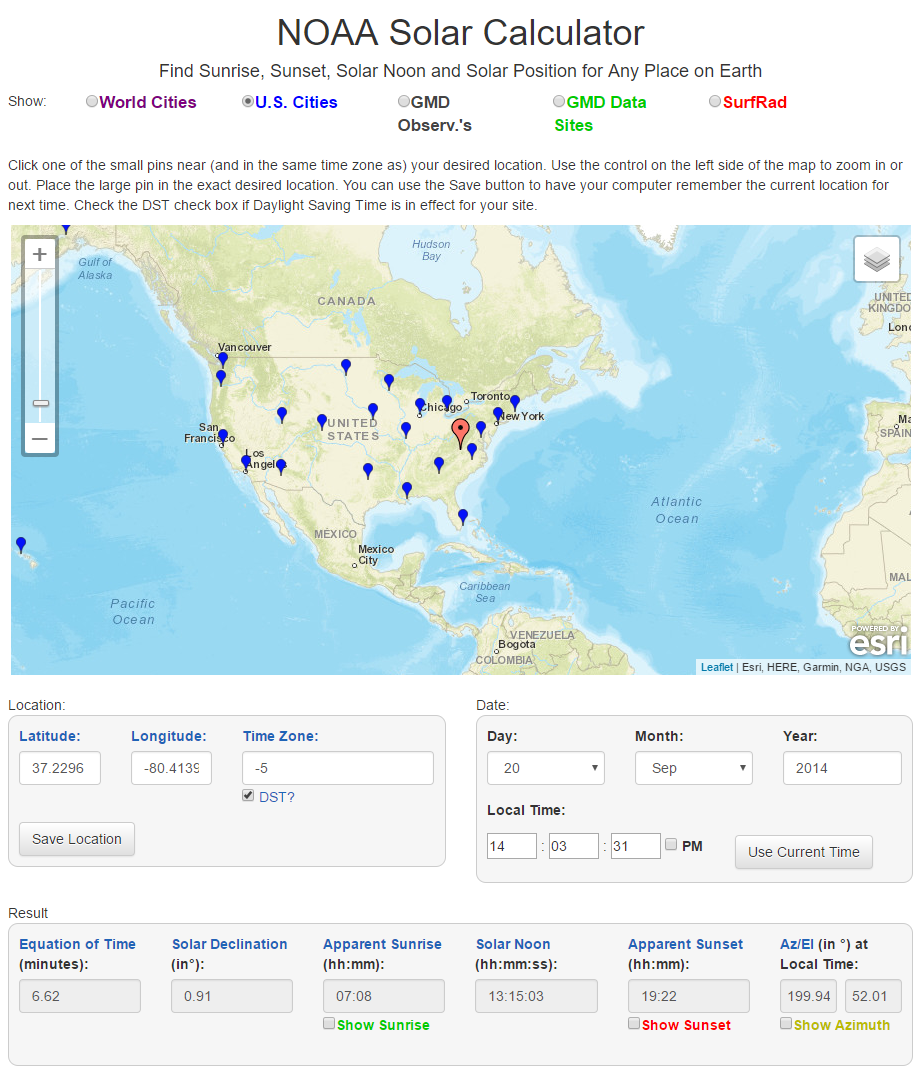

In [11]:
Image("noaa_solar-calc.png")


In [12]:
# enter values from NOAA solar calculator 
t_r = dt.datetime(2014, 9, 20, 7, 8, 0)  # sunrise (hrs since midnight)
t_n = dt.datetime(2014, 9, 20, 13, 15, 3)  # solar noon (hrs since midnight)
t_s = dt.datetime(2014, 9, 20, 19, 22, 0)  # sunset (hrs since midnight)
f = t_s - t_r  # photoperiod (hrs)

## Import temperature data

In [13]:
df_wq = pd.read_csv("lewas_data-WQ_2014-09.csv")  # water quality data from September 2014
df_wq.head()

Date         Time  Temp [deg C]  pH [Units]  SpCond [uS/cm]  \
0  9/20/2014  12:00:00 AM         18.07        8.28             674   
1  9/20/2014  12:03:00 AM         18.05        8.28             675   
2  9/20/2014  12:06:00 AM         18.05        8.28             675   
3  9/20/2014  12:09:00 AM         18.06        8.28             675   
4  9/20/2014  12:12:00 AM         18.06        8.28             676   

   DO [mg/l]  TDS [g/l]  DO% [Sat]  
0       8.13        0.4      102.7  
1       8.12        0.4      102.6  
2       8.15        0.4      102.9  
3       8.15        0.4      102.9  
4       8.14        0.4      102.8

In [14]:
df_wq = pd.read_csv("lewas_data-WQ_2014-09.csv")  # water quality data from September 2014
df_wq['Time'] = pd.to_datetime(df_wq['Time'], format='%I:%M:%S %p').dt.time  # convert to class datetime
df_wq['Date'] = pd.to_datetime(df_wq['Date']).dt.date  # convert to class datetime
for i in range(0, len(df_wq)): 
    df_wq.loc[i, 'Datetime']= dt.datetime.combine(df_wq['Date'][i], df_wq['Time'][i])

### Calculated saturated dissolved oxygen concentration

In [15]:
df_wq['Saturated DO [mg/l]'] = "" # initialize empty array for 'for-loop'

In [16]:
# calculate saturated DO
df_wq['Saturated DO [mg/l]'] = "" # initialize empty array for 'for-loop'
salinity = 0  # assume no salinity in river
elev = 0.634  # elevation of Blacksburg, VA (km)

for i in range(0, len(df_wq)): 
    df_wq.loc[i, 'Saturated DO [mg/l]'] = sat_dissolved_oxygen(df_wq.loc[i, 'Temp [deg C]'], salinity, elev)
    # for info on .loc, see: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy 

## Data exploration

### Plot calculated saturated DO and observed DO for September 20-25, 2014 

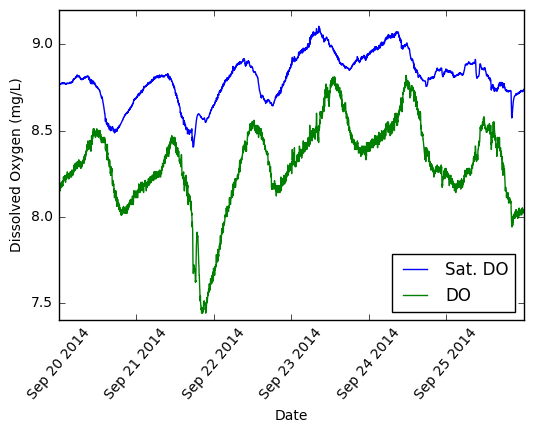

In [17]:
DO = df_wq['DO [mg/l]']
date_time = df_wq['Datetime']
plt.plot(date_time, df_wq['Saturated DO [mg/l]'])
plt.plot(date_time, DO)
plt.xticks(rotation=50)
plt.legend(['Sat. DO', 'DO'], loc='lower right')
plt.xlabel('Date')
plt.ylabel('Dissolved Oxygen (mg/L)')

### Plot calculated saturated DO and observed DO for a single day (September 20, 2014)

In [18]:
df_day = df_wq[(df_wq['Date'] < dt.date(2014, 9, 21))]
date_time = df_day['Datetime']

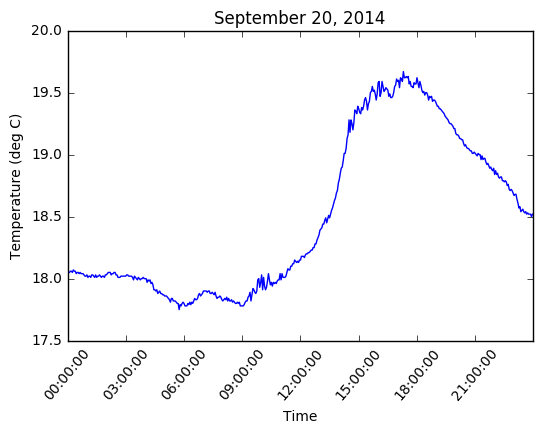

In [19]:
temp = df_day['Temp [deg C]']
plt.figure()
plt.plot(date_time, temp)
plt.xticks(rotation=50)
plt.xlabel("Time")
plt.ylabel("Temperature (deg C)")
plt.title('September 20, 2014')

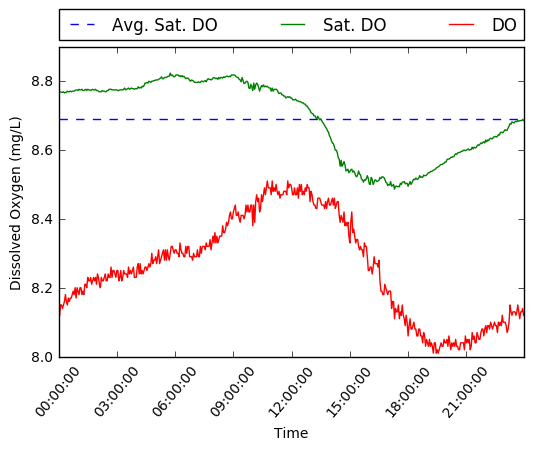

In [20]:
plt.figure()
o_sat = pd.to_numeric(df_day['Saturated DO [mg/l]'])
o_sat_avg = np.repeat(np.mean(o_sat), len(o_sat))
DO = df_day['DO [mg/l]']
date_time = df_day['Datetime']
plt.plot(date_time, o_sat_avg, '--')
plt.plot(date_time, o_sat)
plt.plot(date_time, DO)
plt.xticks(rotation=50)
plt.legend(['Avg. Sat. DO', 'Sat. DO', 'DO'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')

## Sequentially solve for reaeration, primary production, and respiration with delta method using look-up tables provided in Chapra (2008)

In [21]:
D = o_sat - DO  # DO deficit

In [22]:
# Find time of minimum deficit
idx_Dmin = np.where(D==D.min())[0][0]  # index corresponding to time of min. deficit
t_Dmin = date_time[idx_Dmin]  # time of minimum deficit (datetime)

idx_noon = 256  # index corresponding to time of solar noon 
t_noon =date_time[idx_noon]  # solar noon (datetime)

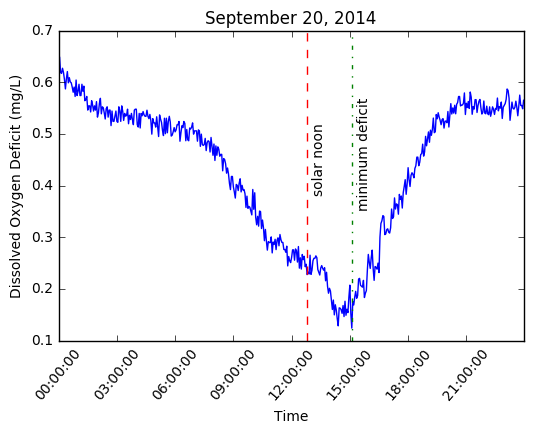

In [23]:
plt.figure()
plt.plot(date_time, D)

plt.axvline(date_time[idx_noon], linestyle='--', color='r')
plt.text(date_time[idx_noon + 5], 0.5, 'solar noon', rotation=90)

plt.axvline(t_Dmin, linestyle='-.', color='g')
plt.text(date_time[idx_Dmin + 5], 0.55, 'minimum deficit', rotation=90)

plt.xticks(rotation=50)
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen Deficit (mg/L)')
plt.title('September 20, 2014')

### Solve for phi and delta

In [24]:
phi = (t_Dmin.hour + t_Dmin.minute/60 + t_Dmin.second/3600) - (t_noon.hour + t_noon.minute/60 + t_noon.second/3600)  # time lag between minimum deficit and solar noon (hrs)
print("Phi:", round(phi, 2))

delta = np.max(D) - np.min(D)  # range of deficit values (mg/L)
print("Delta:", round(delta, 2))

Phi: 2.3
Delta: 0.52


### Using time lag and photoperiod, solve for reaeration coefficient

Estimate reaeration from Figure 24.5 in Chapra (2008) based on f and phi.

In [25]:
k_a = 9  # reaeration coefficient (1/d)

### Using reaeration coefficient,  photoperiod, and delta, solve for primary production rate

Estimate average daily photosynthesis from Figure 24.6 in Chapra (2008) based on k_a, f, and delta.

In [26]:
delta_over_P = 0.28  # y-axis of Figure 24.6 
P = delta/delta_over_P  # primary production rate (mg/L/d)
print("Primary production rate:", round(P, 2), "mg/L/d")

Primary production rate: 1.87 mg/L/d


### Calculate respiration

In [27]:
R = P + k_a*np.mean(DO)  # respiration (mg/L/d), equation 24.31 of Chapra (2008)
print("Respiration:", round(R, 2), "mg/L/d")

Respiration: 76.2 mg/L/d


### Check reaeration calculation with Owens-Gibbs estimate of reaeration

In [28]:
# since no flow data is available for 9/20/14, I used the average velocity and stage from 9/13

H = 0.383 + 0.128 # Stage(m) = FlowMeterStage(m) + 0.128, see http://www.lewas.centers.vt.edu/dataviewer/data_corrections.html
U = 0.3  # approximated based on the relationship between stage and velocity on live LEWAS Data viewer (http://www.lewas.centers.vt.edu/dataviewer/single_graph.html)
# calculate reaeration
k_a_OG = 5.32*(U**0.67)/(H**1.85)  # reaeration rate (1/d), based on eq. 20.43 in Chapra (2008) adapted from Owens et al. (1964)
print("Reaeration coefficient predicted by Owens-Gibbs:", round(k_a_OG, 2), "1/d")

Reaeration coefficient predicted by Owens-Gibbs: 8.22 1/d


### Recalculate primary production and respiration based on new reaeration calculation

In [29]:
delta_over_P_2 = 0.3  # y-axis of Figure 24.6 
P_2 = delta/delta_over_P_2  # primary production rate (mg/L/d)
print("Recalculated primary production rate:", round(P_2, 2), "mg/L/d")

R_2 = P_2 + k_a_OG*np.mean(DO)  # respiration (mg/L/d), equation 24.31 of Chapra (2008)
print("Respiration:", round(R_2, 2), "mg/L/d")

Recalculated primary production rate: 1.75 mg/L/d
Respiration: 69.65 mg/L/d


DISCUSSION








.
.
.
.
.
.
.


## Fit observed DO to sine curve by least squares regression

Amplitude:  0.190465306096
Phase:  -1.10296876493
Mean:  8.25837499962


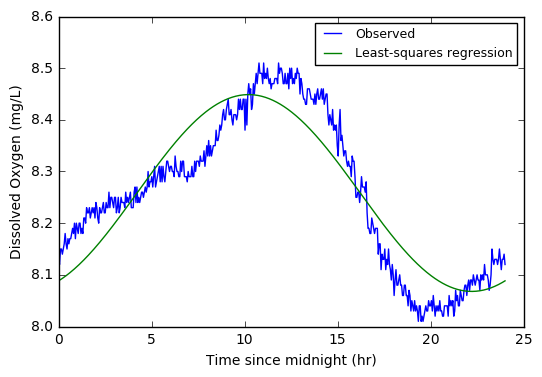

In [30]:
# source: http://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy by Dhara. accessed: 5/1/17

# inputs for sine fitting (user can change these!)
data = df_day['DO [mg/l]']  # dissolved oxygen (mg/L)
period = 1  # assume only 1 period for one day

# guesses for three fitting parameters: mean, amplitude, and phase
guess_mean = np.mean(data)
guess_amp = 3*np.std(data)/(2**0.5)
guess_phase = 0

t = np.linspace(0, 2*np.pi*period, len(data))
data_first_guess = guess_amp*np.sin(t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters

optimize_func = lambda x: x[0]*np.sin(t+x[1]) + x[2] - data
est_amp, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_phase, guess_mean])[0]

print("Amplitude: ", est_amp)
print("Phase: ", est_phase)
print("Mean: ", est_mean)

# recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(t+est_phase) + est_mean

time = np.linspace(0, 24, len(data))
plt.plot(time, data, label='Observed')
plt.plot(time, data_fit, label='Least-squares regression')
plt.xlabel('Time since midnight (hr)')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend(prop={'size':9})
plt.show()